In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import  FuncFormatter, FormatStrFormatter

# %pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


In [2]:
# manage spotify credentials
cid =''
secret =''

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [2]:
"""
import spotify csv files with customised settings
"""
def import_csv(file_path: str):
  return pd.read_csv(file_path, header=0, index_col=0)

# check if CompileData folder exist
import_folder_path = os.path.join("..", "datasets", "CompileData")
if not os.path.exists(import_folder_path):
  raise Exception("Dataset CompileData not found! Run scraper.ipynb to get the datasets") 

# export folder path
spotify_eda_folder_path = os.path.join("..", "datasets", "SpotifyAudioFeatures")
if not os.path.exists(spotify_eda_folder_path):
  os.makedirs(spotify_eda_folder_path)

# export image path
image_export_folder_path = os.path.join("..", "images", "EDA")
if not os.path.exists(image_export_folder_path):
  os.makedirs(image_export_folder_path)

## Get audio features of songs from spotify

In [ ]:
def get_spotify_data(uid_list: list[str]):
  combined_info_list: list[dict] = []
  # we split into chunks to reduce number of calls to spotify
  # spotify chunk_size limitations is actually 100, but use 50 to be safe
  chunk_size = 50

  for i in range(0, len(uid_list), chunk_size):
    split_list = uid_list[i:i+chunk_size]
    info_list = sp.audio_features(split_list)
    combined_info_list.extend(info_list)

  return combined_info_list

In [ ]:
# get 2017-2021 csv files and get the danceability scores
start_year = 2017
end_year = 2021

while start_year <= end_year:
  print("Staring with", start_year)
  path = os.path.join(
    import_folder_path,
    str(start_year) + "_spotify_data_and_lyrics.csv"
  )
  df: pd.DataFrame = pd.read_csv(path, header=0, index_col=0)
  # drop lyrics to save memory, we probably don't need it 
  df.drop(columns=["lyrics"], inplace=True)

  uid_list: list[str] = df['uid'].values.tolist()
  spotify_data_list = get_spotify_data(uid_list)
  df_spotify_data = pd.DataFrame.from_dict(spotify_data_list)

  df_combined = pd.merge(df, df_spotify_data, left_on=["uid"], right_on=["id"])
  df_combined.drop(columns=["id", "uri", "track_href", "analysis_url"], inplace=True)

  # export to excel
  df_combined.to_csv(
    spotify_eda_folder_path + "/" + str(start_year) + "_spotify_audio_features.csv", 
    encoding="utf-8-sig"
  )

  start_year = start_year + 1


## Prepare CSV files

In [3]:
# load csv file create above
songs2017 = import_csv(os.path.join(spotify_eda_folder_path, '2017_spotify_audio_features.csv'))
songs2018 = import_csv(os.path.join(spotify_eda_folder_path, '2018_spotify_audio_features.csv'))
songs2019 = import_csv(os.path.join(spotify_eda_folder_path, '2019_spotify_audio_features.csv'))
songs2020 = import_csv(os.path.join(spotify_eda_folder_path, '2020_spotify_audio_features.csv'))
songs2021 = import_csv(os.path.join(spotify_eda_folder_path, '2021_spotify_audio_features.csv'))

songs2017["year"] = 2017
songs2018["year"] = 2018
songs2019["year"] = 2019
songs2020["year"] = 2020
songs2021["year"] = 2021


## Compare Audio Features between years

In [4]:
# eda comparision between years
# create a single df containing everything
df_songs_overall = pd.concat([songs2017, songs2018, songs2019, songs2020, songs2021])
df_songs_overall.head(5)


,track_name,artist,streams,uid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,year
0,Shape of You,Ed Sheeran,1514648943,7qiZfU4dY1lWllzX7mPBI3,0.825,0.652,1,-3.183,0,0.0802,0.581000,0.000000,0.0931,0.931,95.977,audio_features,233713,4,2017
1,Despacito - Remix,"Luis Fonsi, Daddy Yankee, Justin Bieber",959547937,5CtI0qwDJkDQGwXD1H1cLb,0.694,0.815,2,-4.328,1,0.1200,0.229000,0.000000,0.0924,0.813,88.931,audio_features,228827,4,2017
2,Despacito,"Luis Fonsi, Daddy Yankee",749764667,4aWmUDTfIPGksMNLV2rQP2,0.660,0.786,2,-4.757,1,0.1700,0.209000,0.000000,0.1120,0.846,177.833,audio_features,228200,4,2017
3,Something Just Like This,"The Chainsmokers, Coldplay",704250265,6RUKPb4LETWmmr3iAEQktW,0.617,0.635,11,-6.769,0,0.0317,0.049800,0.000014,0.1640,0.446,103.019,audio_features,247160,4,2017
4,HUMBLE.,Kendrick Lamar,665416406,7KXjTSCq5nL1LoYtL7XAwS,0.908,0.621,1,-6.638,0,0.1020,0.000282,0.000054,0.0958,0.421,150.011,audio_features,177000,4,2017


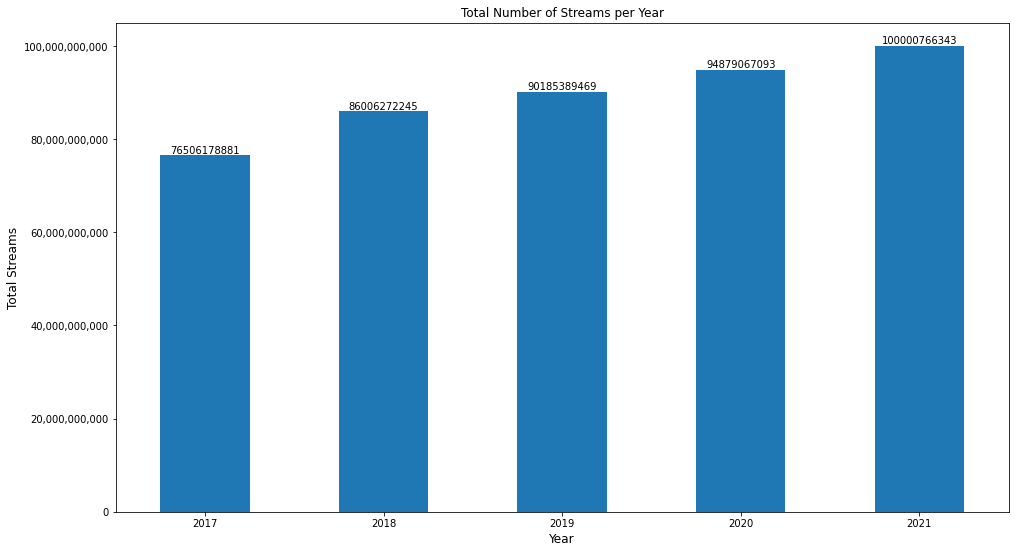

In [5]:
# Lets plot the streams over years
df_songs_yearly_streams = pd.DataFrame()

for year in range(2017, 2021 + 1):
  temp_df: pd.DataFrame = df_songs_overall.loc[df_songs_overall['year'] == year]
  yearly_row = {
    "year": year,
    "total_streams": temp_df['streams'].sum()
  }
  df_songs_yearly_streams = df_songs_yearly_streams.append(yearly_row, ignore_index=True )

df_songs_yearly_streams['year'] = df_songs_yearly_streams['year'].astype('int')
df_songs_yearly_streams['total_streams'] = df_songs_yearly_streams['total_streams'].astype('int')
df_songs_yearly_streams.set_index('year', inplace=True)

ax = df_songs_yearly_streams.plot(title="Total Number of Streams per Year", figsize=(16, 9), kind="bar", legend=False)
ax.set_ylabel("Total Streams", fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.bar_label(ax.containers[0], fmt='%d')

# remove scientific notation
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xticks(rotation=0)
plt.draw()
plt.savefig(os.path.join(image_export_folder_path, "yearly_streams"), facecolor="white")

In [6]:
# Lets plot the audio features over years
df_songs_yearly_features = pd.DataFrame()

for year in range(2017, 2021 + 1):
  temp_df: pd.DataFrame = df_songs_overall.loc[df_songs_overall['year'] == year]
  yearly_row = {
    "year": year,
    "danceability": temp_df['danceability'].mean(),
    "energy": temp_df['energy'].mean(),
    "loudness": temp_df['loudness'].mean(),
    "speechiness": temp_df['speechiness'].mean(),
    "acousticness": temp_df['acousticness'].mean(),
    "instrumentalness": temp_df['instrumentalness'].mean(),
    "liveness": temp_df['liveness'].mean(),
    "valence": temp_df['valence'].mean(),
    "tempo": temp_df['tempo'].mean(),
  }
  df_songs_yearly_features = df_songs_yearly_features.append(yearly_row, ignore_index=True )

df_songs_yearly_features['year'] = df_songs_yearly_features['year'].astype('int')
df_songs_yearly_features['danceability'] = df_songs_yearly_features['danceability'].astype('float')
df_songs_yearly_features['energy'] = df_songs_yearly_features['energy'].astype('float')
df_songs_yearly_features['loudness'] = df_songs_yearly_features['loudness'].astype('float')
df_songs_yearly_features['speechiness'] = df_songs_yearly_features['speechiness'].astype('float')
df_songs_yearly_features['acousticness'] = df_songs_yearly_features['acousticness'].astype('float')
df_songs_yearly_features['instrumentalness'] = df_songs_yearly_features['instrumentalness'].astype('float')
df_songs_yearly_features['liveness'] = df_songs_yearly_features['liveness'].astype('float')
df_songs_yearly_features['valence'] = df_songs_yearly_features['valence'].astype('float')
df_songs_yearly_features['tempo'] = df_songs_yearly_features['tempo'].astype('float')
df_songs_yearly_features.set_index('year', inplace=True)

df_removed_features = df_songs_yearly_features.drop(columns=["tempo", "loudness"])
df_removed_features.head()


,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence
year,,,,,,,
2017,0.672924,0.637476,0.118247,0.205526,0.007338,0.177119,0.471953
2018,0.690187,0.633121,0.132666,0.221024,0.007973,0.177120,0.477791
2019,0.684725,0.626569,0.126559,0.256200,0.012215,0.173399,0.498146
2020,0.697798,0.628650,0.124161,0.244195,0.011037,0.181303,0.513015
2021,0.661180,0.628640,0.107230,0.263682,0.012751,0.178184,0.512880


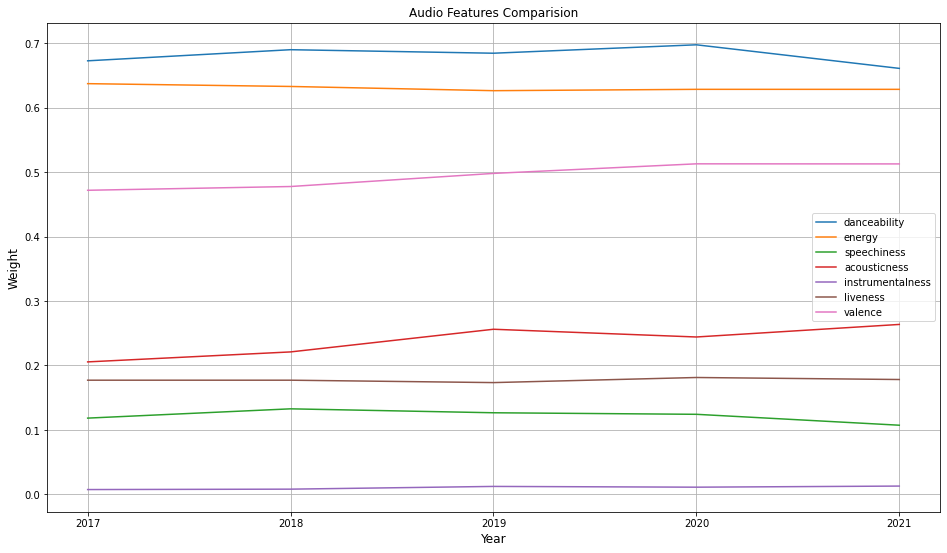

In [7]:
ax = df_removed_features.plot(title="Audio Features Comparision", figsize=(16, 9), grid=True)
ax.set_ylabel("Weight", fontsize=12)
ax.set_xlabel("Year", fontsize=12)

plt.xticks(df_removed_features.index, rotation=0)
plt.draw()
plt.savefig(os.path.join(image_export_folder_path, "audio_features_1"), facecolor="white")

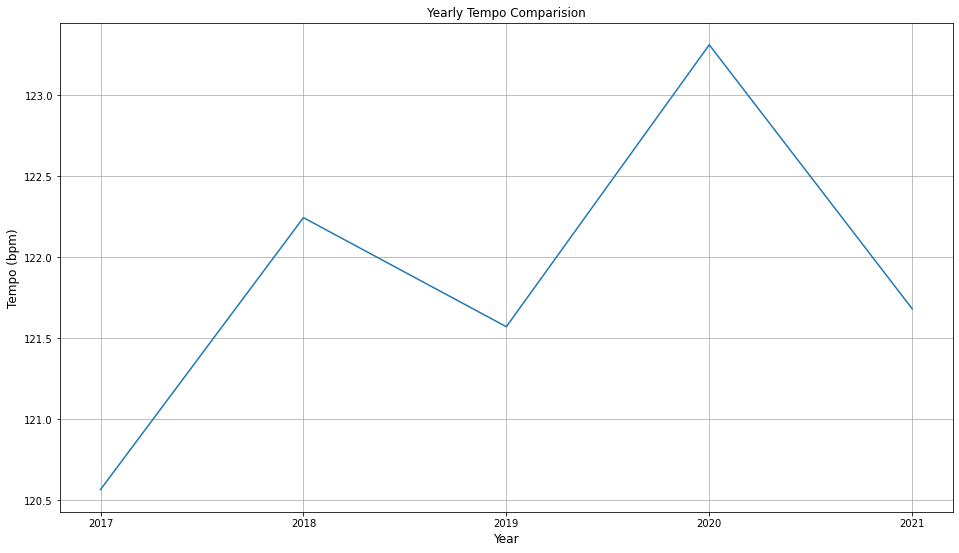

In [8]:
# get average yearly tempo

df_yearly_tempo = df_songs_yearly_features.loc[:, "tempo"]
ax = df_yearly_tempo.plot(title="Yearly Tempo Comparision", figsize=(16, 9), grid=True)
ax.set_ylabel("Tempo (bpm)", fontsize=12)
ax.set_xlabel("Year", fontsize=12)

plt.xticks(df_removed_features.index, rotation=0)
plt.draw()
plt.savefig(os.path.join(image_export_folder_path, "audio_features_2"), facecolor="white")


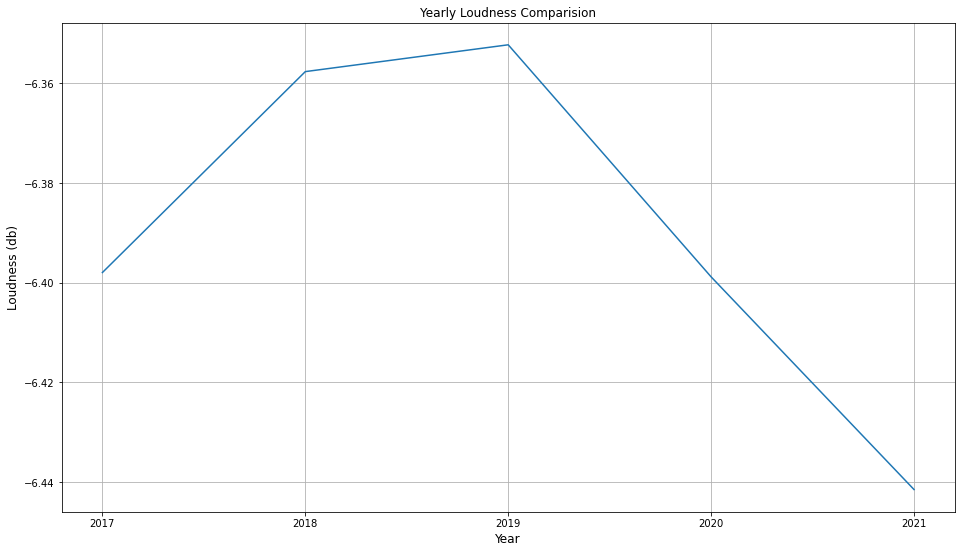

In [13]:
# get average yearly loudness

df_yearly_tempo = df_songs_yearly_features.loc[:, "loudness"]
ax = df_yearly_tempo.plot(title="Yearly Loudness Comparision", figsize=(16, 9), grid=True)
ax.set_ylabel("Loudness (db)", fontsize=12)
ax.set_xlabel("Year", fontsize=12)

plt.xticks(df_removed_features.index, rotation=0)
plt.draw()
plt.savefig(os.path.join(image_export_folder_path, "audio_features_3"), facecolor="white")


In [10]:
print("End of Program")

End of Program
